# Customer Segmentation Report

In [1]:
%matplotlib inline
import psycopg2
import pickle

# data processing
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from feature_engine.encoding import RareLabelEncoder
from feature_engine.outliers import Winsorizer

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Supervised Learning
from imblearn.under_sampling import RandomUnderSampler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

# Model Evaluation
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import recall_score, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Explainability
import graphviz
import shap

# Utility Functions

In [2]:
def get_data_from_my_postgre_db(password:str, table_name:str)->pd.DataFrame:
    """connects to marketing_analytics db and returns data from table_name as pandas dataframe .
    inputs: database password and table_name"""
    # Connect to the database
    conn = psycopg2.connect(
        database="marketing_analytics", 
        user="postgres", 
        password=password, 
        host="localhost", 
        port="5432")
    # Create a cursor object
    cur = conn.cursor()
    # Execute a SQL query
    #cur.execute("SELECT * FROM bank_customers_churn_dataset")
    cur.execute("SELECT * FROM " + table_name) 
    # Get the column names from the cursor description
    columns = [desc[0] for desc in cur.description]
    # Fetch the results i.e. values
    results = cur.fetchall()
    # Create a dictionary mapping column names to values
    data = [dict(zip(columns, row)) for row in results]
    # Close the connection
    conn.close()
    # turn dictionary into dataframe
    return pd.DataFrame.from_dict(data)

def calculate_engagement_rate(data:pd.DataFrame)->float:
    """get the marketing engagement rate in percent given data frame with column "converter" labeling whether canverted or not"""
    conversion_rate_pct = np.round((data.groupby(by='converter').count().iloc[:,0] / data.shape[0] * 100) [1],2)
    return conversion_rate_pct

def plot_threshold_recall_precision_curves(model, X, y):
    """plot threshold-recall-precision curves given trained model X and y"""
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))

    y_scores = model.predict_proba(X)[:,1]
    precision, recall, thresholds = precision_recall_curve(y, y_scores)

    ax[0].plot(recall, precision)
    ax[0].set_title("Precision-Recall Curve")
    ax[0].set_xlabel('recall')
    ax[0].set_ylabel('precision')
    ax[0].set_xlim(-0.05, 1.05)
    ax[0].set_ylim(-0.05, 1.05)
    ax[0].grid()

    ax[1].plot(recall, np.insert(thresholds, 0, 0))
    ax[1].set_title("Threshold-Recall Curve")
    ax[1].set_xlabel('recall')
    ax[1].set_ylabel('threshold')
    ax[1].set_xlim(-0.05, 1.05)
    ax[1].set_ylim(-0.05, 1.05)
    ax[1].grid()
    return fig

def plot_confusion_matrix(features:pd.DataFrame, labels:np.array, sklearn_model, threshold=0.5):
    """plot confusion matrix for trained model given labels and one-hotencoded features. Pick a decision threshold for positive class"""
    # make predictions
    preds = sklearn_model.predict_proba(features)[:,1]
    preds = np.where(preds>threshold, 1, 0)
    # calc confusion matrix
    cm = confusion_matrix(labels, preds, labels=sklearn_model.classes_)
    # create matrix display
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,                            
        display_labels=sklearn_model.classes_)
    disp.plot()
    plt.show()

def plot_cluster_shap_values(shap_values, cluster=0, topn=5):
    """Violin plot of the shap values for cluster"""
    shap.summary_plot(
        shap_values = shap_values[cluster], 
        features = X,
        sort=True,
        plot_size=(12.0,6.0),
        show=False,
        max_display=topn,
        plot_type='violin'
        )
    ax=plt.gca()
    ax.set_title('Shap Feature Importance for Cluster {}'.format(cluster))
    ax.grid()
    ax.set_xlim(-.5,.5)
    fig = plt.gcf()
    plt.show()

# Data Infos

the dataset is available here: https://archive.ics.uci.edu/ml/datasets/bank+marketing

Find the best strategies to improve for the next marketing campaign. How can the financial institution have a greater effectiveness for future marketing campaigns? In order to answer this, we have to analyze the last marketing campaign the bank performed and identify the patterns that will help us find conclusions in order to develop future strategies. In this demo, we focus on identitying the key drivers to marketing engagement

## Attribute Information:

Input variables:
### bank client data:
- age (numeric)
- job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- default: has credit in default? (categorical: 'no','yes','unknown')
- housing: has housing loan? (categorical: 'no','yes','unknown')
- loan: has personal loan? (categorical: 'no','yes','unknown')
### related with the last contact of the current campaign:
- contact: contact communication type (categorical: 'cellular','telephone')
- month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
### other attributes:
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
### social and economic context attributes
- emp.var.rate: employment variation rate - quarterly indicator (numeric)
- cons.price.idx: consumer price index - monthly indicator (numeric)
- cons.conf.idx: consumer confidence index - monthly indicator (numeric)
- euribor3m: euribor 3 month rate - daily indicator (numeric)
- nr.employed: number of employees - quarterly indicator (numeric)

### Output variable (desired target):
- y - has the client subscribed a term deposit? (binary: 'yes','no')

# Import Data

In [3]:
# load data from local csv 
df = pd.read_csv(
        filepath_or_buffer = '../data/bank-additional-full.csv',
        sep=';'
)

# drop a few columns which are typically not available in many scenarios or columns which leads to leakage b/c it cannot be known beforehand!
df.drop(
        labels=['duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx','euribor3m', 'nr.employed'], 
        axis=1, 
        inplace=True)

# make feature denoting if there was a previous contact
df['previous_contact'] = (df['pdays'] != 999).apply(lambda x: 'no' if x==False else 'yes')

# insert random value if value equal 999 since the values is not defined
df['pdays'] = df['pdays'].apply(lambda x: np.nan if x==999 else x)

# encode target column
df['y'] = df['y'].apply(lambda x: 0 if x=='no' else 1)

df.head()

Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,y,previous_contact
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,NaN,0,nonexistent,0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,NaN,0,nonexistent,0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,NaN,0,nonexistent,0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,NaN,0,nonexistent,0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,NaN,0,nonexistent,0,no


In [4]:
# divide features and target
y = df['y'].values
X = df.drop('y', axis=1)

In [5]:
# get numeric and categorical columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_columns = X.select_dtypes(include=numerics).columns.to_list()
categorical_columns = X.select_dtypes(exclude=numerics).columns.to_list()

print('numeric columns: {}'.format(numeric_columns))
print('categorical columns: {}'.format(categorical_columns))

numeric columns: ['age', 'campaign', 'pdays', 'previous']
categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'previous_contact']


# Load Model Artifacts

In [6]:
with open('../artifacts/numeric_imputer.pickle', 'rb') as filename: # trained model to impute missing numeric data
    numeric_imputer = pickle.load(filename)

with open('../artifacts/categorical_imputer.pickle', 'rb') as filename: # trained model to impute missing categorical data
    categorical_imputer = pickle.load(filename) 

with open('../artifacts/rare_encoder.pickle', 'rb') as filename: # trained model to encode rare labels
    rare_encoder = pickle.load(filename)

with open('../artifacts/capper.pickle', 'rb') as filename: # trained model to cap outliers
    capper = pickle.load(filename)   

with open('../artifacts/enc.pickle', 'rb') as filename: # trained one hot encoder
    enc = pickle.load(filename)

with open('../artifacts/model.pickle', 'rb') as filename: # trained random forrest classifier
    model = pickle.load(filename)

In [7]:
# impute mising numeric features
X_numeric = pd.DataFrame(
    numeric_imputer.transform(X[numeric_columns]), 
    columns=numeric_columns, 
    index=X.index)

# reformat to integer
X_numeric['previous'] = X_numeric['previous'].apply(lambda x: np.round(x,0)).astype('int')
X_numeric['campaign'] = X_numeric['campaign'].apply(lambda x: np.round(x,0)).astype('int')

# impute mising categorical features
X_categorical = pd.DataFrame(
    categorical_imputer.transform(X[categorical_columns]), 
    columns=categorical_columns, 
    index=X.index)

# concate numeric and categorical features
X = pd.concat([X_numeric, X_categorical], axis=1)

# remove rare labels
X[categorical_columns] = rare_encoder.transform(X[categorical_columns])

# remove outliers
X[numeric_columns] = capper.transform(X[numeric_columns])

# one hot encoding categorical features
X_cat_hotenc = pd.DataFrame(
    enc.transform(X[categorical_columns]), 
    columns=enc.get_feature_names_out(),
    index=X.index) 

# concate numeric and hot-encoded categorical features
X_hotenc = pd.concat([X[numeric_columns], X_cat_hotenc], axis=1)

## concate numeric and hot-encoded categorical features
df = pd.concat([X[numeric_columns], X[categorical_columns], pd.DataFrame(y, index=X.index, columns=['converter'])], axis=1)

df.head()

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros


,age,campaign,pdays,previous,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,previous_contact,converter
0,56.0,1.0,16.084518,0.0,Rare,married,basic.4y,no,no,no,telephone,may,mon,nonexistent,no,0
1,57.0,1.0,16.084518,0.0,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent,no,0
2,37.0,1.0,16.084518,0.0,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent,no,0
3,40.0,1.0,16.084518,0.0,admin.,married,Rare,no,no,no,telephone,may,mon,nonexistent,no,0
4,56.0,1.0,16.084518,0.0,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent,no,0


# Data Visualization

## Engagement Rate

In [8]:
print('Conversion rate: {} %'.format(calculate_engagement_rate(df))) 

Conversion rate: 11.27 %


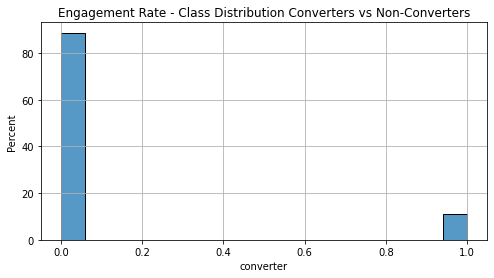

In [9]:
### Visualize Class Distribution

# plot class distribution for converters vs non-converters
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.histplot(
        data = df,
        x = 'converter',
        stat='percent',
        ax=ax
)
plt.grid()
plt.title('Engagement Rate - Class Distribution Converters vs Non-Converters')
plt.show()

## Visualize Numerical Features

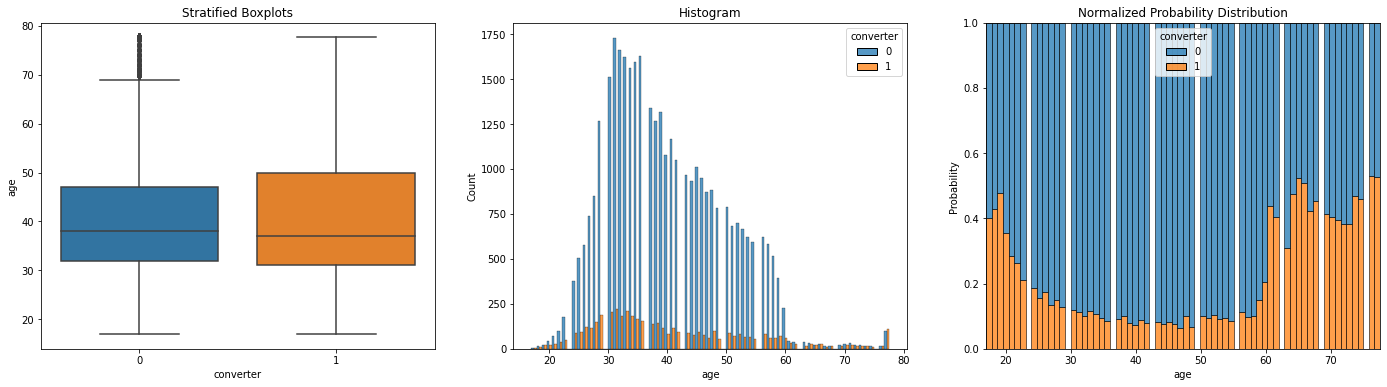

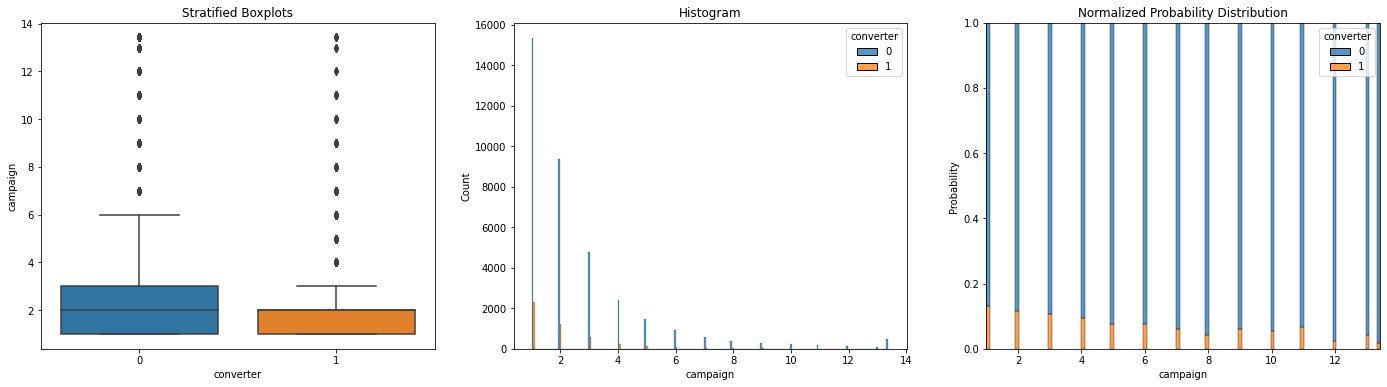

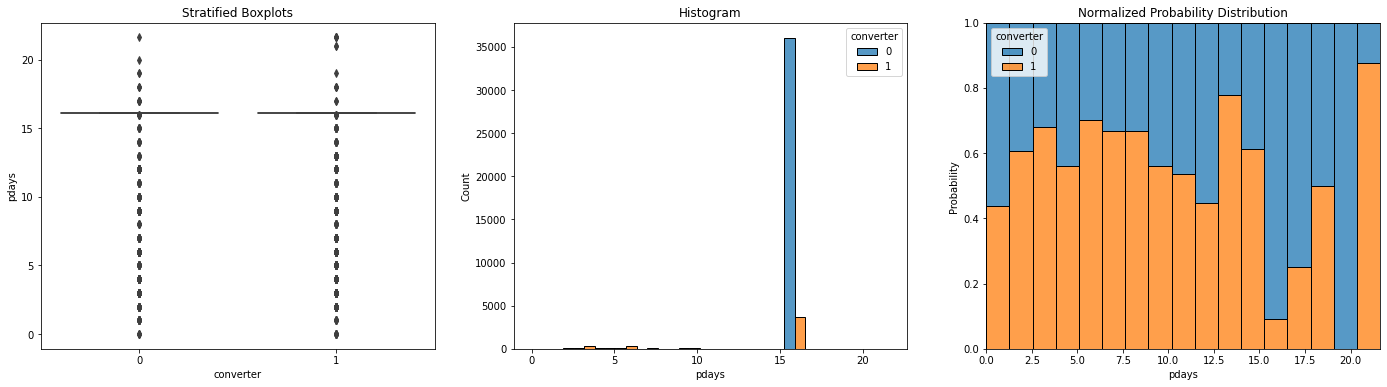

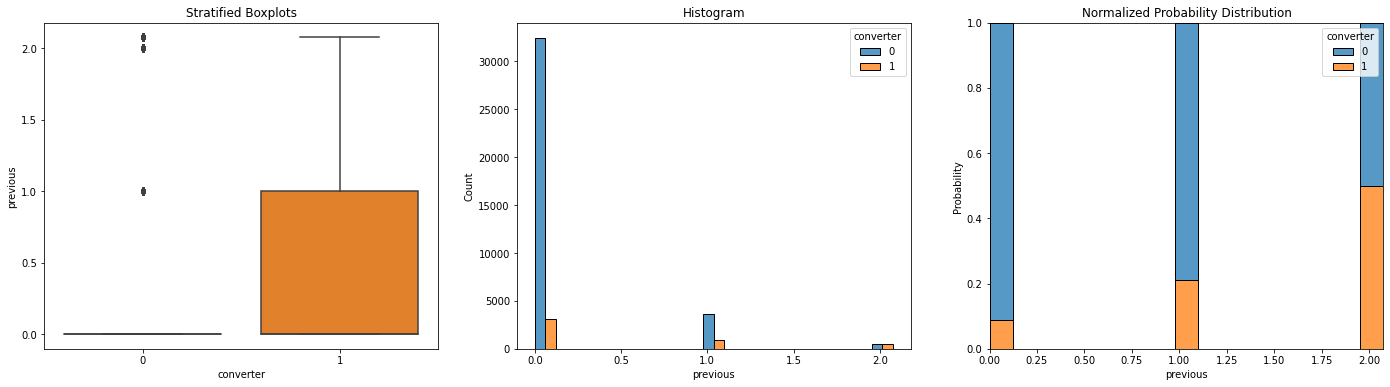

In [10]:
# plot box-plots and histograms
for feat in numeric_columns:

    fig, ax = plt.subplots(1, 3, figsize=(24,6))

    sns.boxplot(
        data = df,
        y = feat,
        x = 'converter',
        ax=ax[0]
    )
    ax[0].set_title('Stratified Boxplots')

    sns.histplot(
        data = df,
        x = feat,
        hue = 'converter',
        stat='count',
        multiple='dodge',
        ax = ax[1]
    )
    ax[1].set_title('Histogram')

    sns.histplot(
        data = df,
        x = feat,
        hue = 'converter',
        stat='probability',
        multiple='fill',
        ax = ax[2]
    )
    ax[2].set_title('Normalized Probability Distribution')

    plt.show()

## Visualize Categorical Features

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


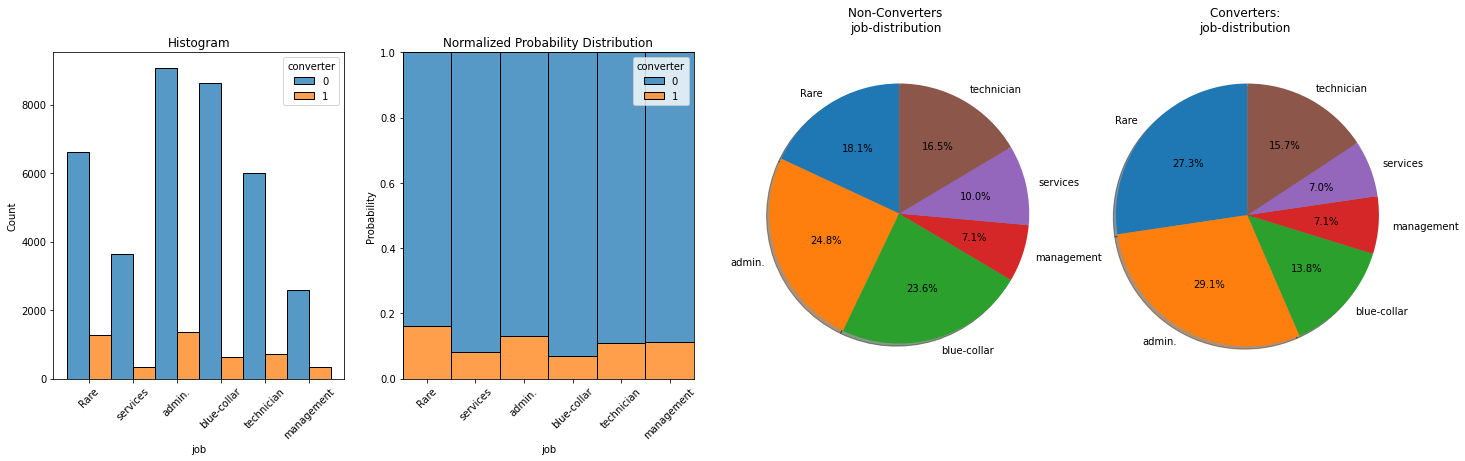

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


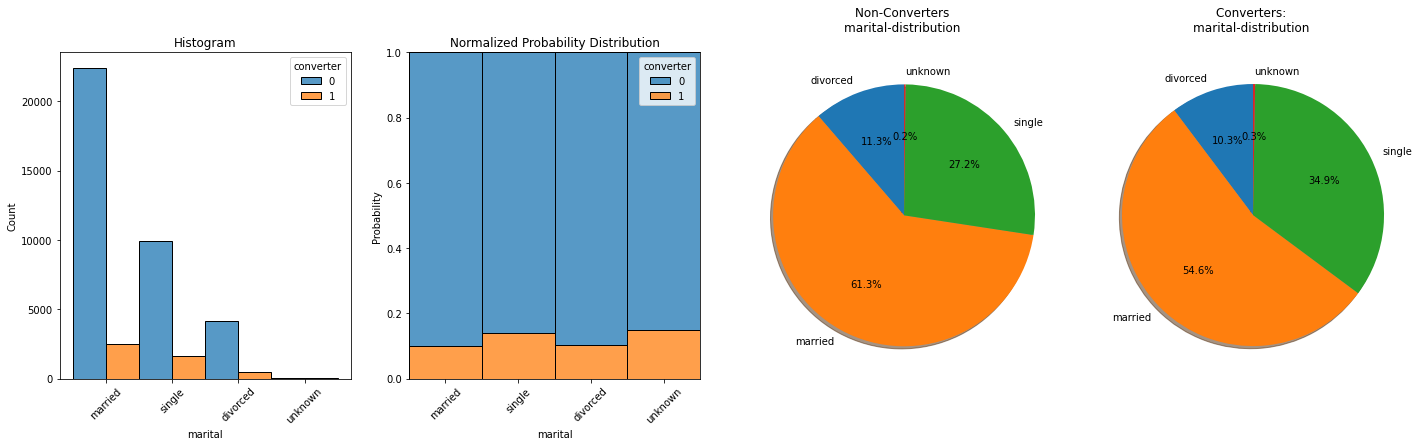

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


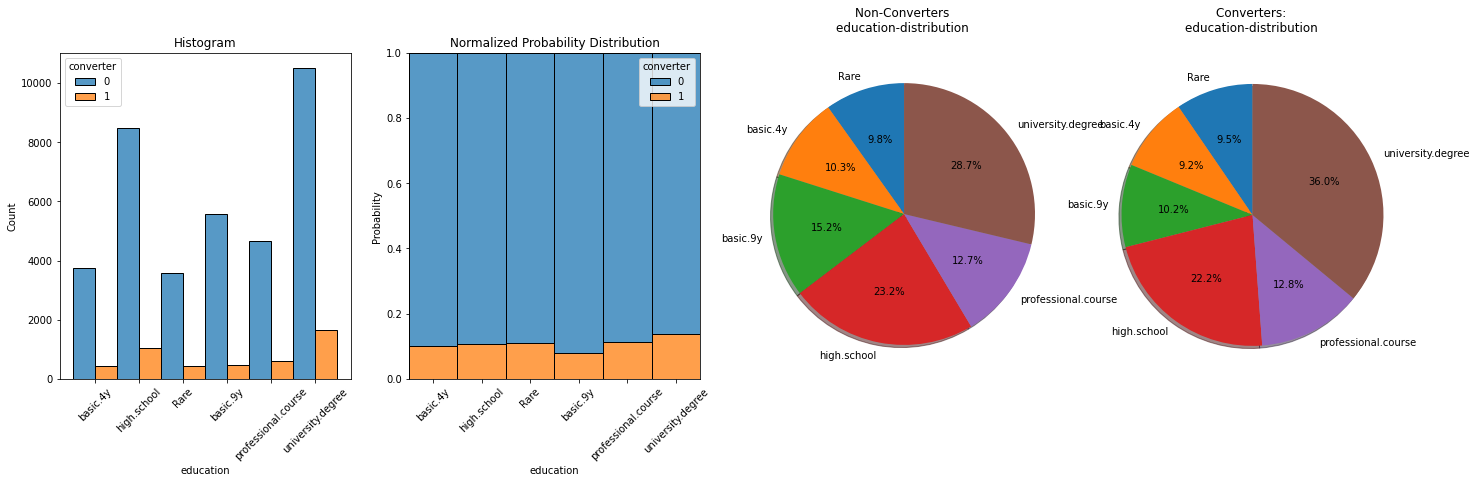

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


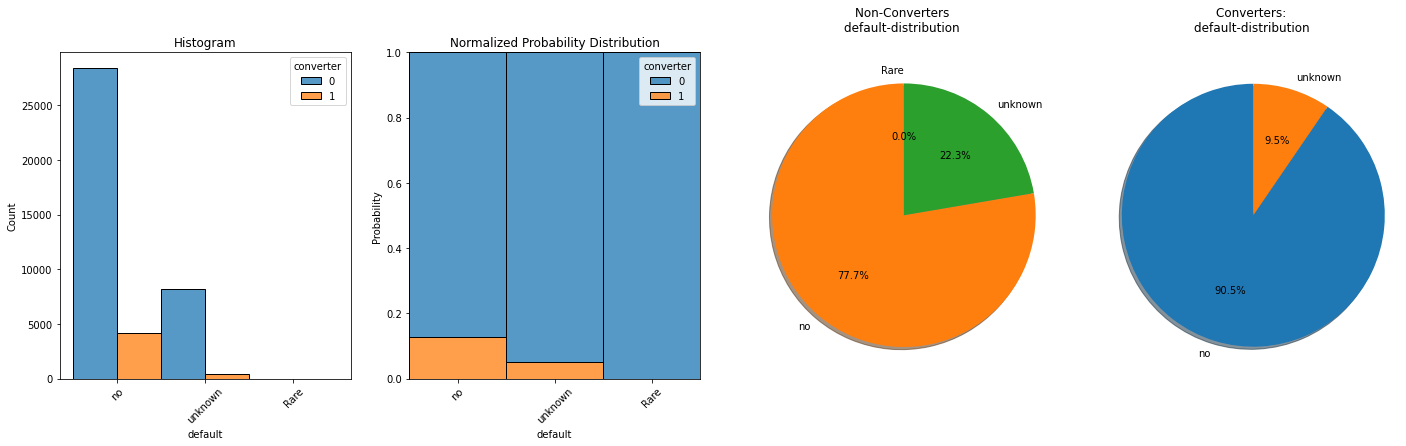

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


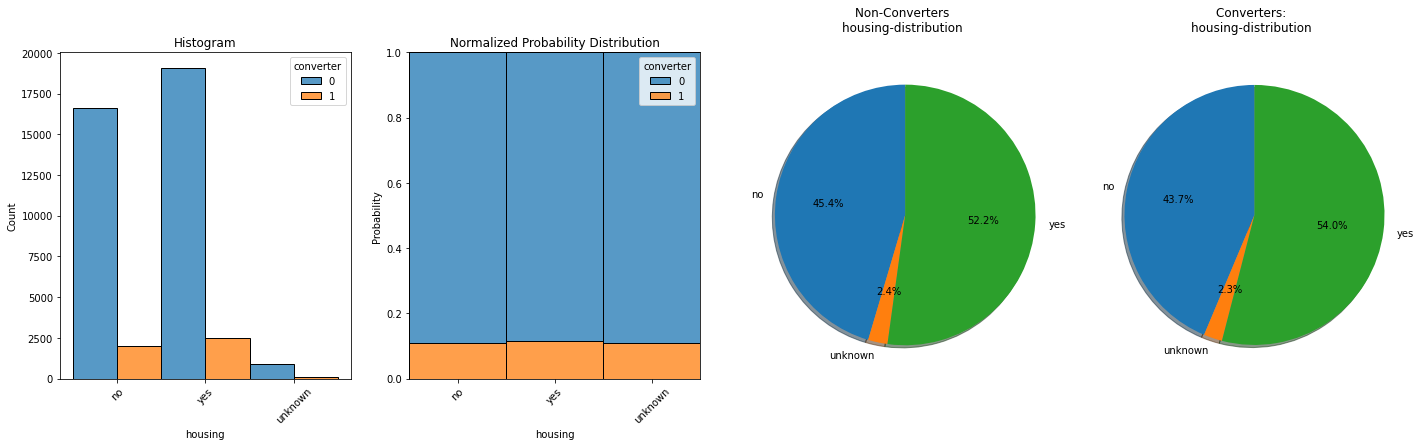

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


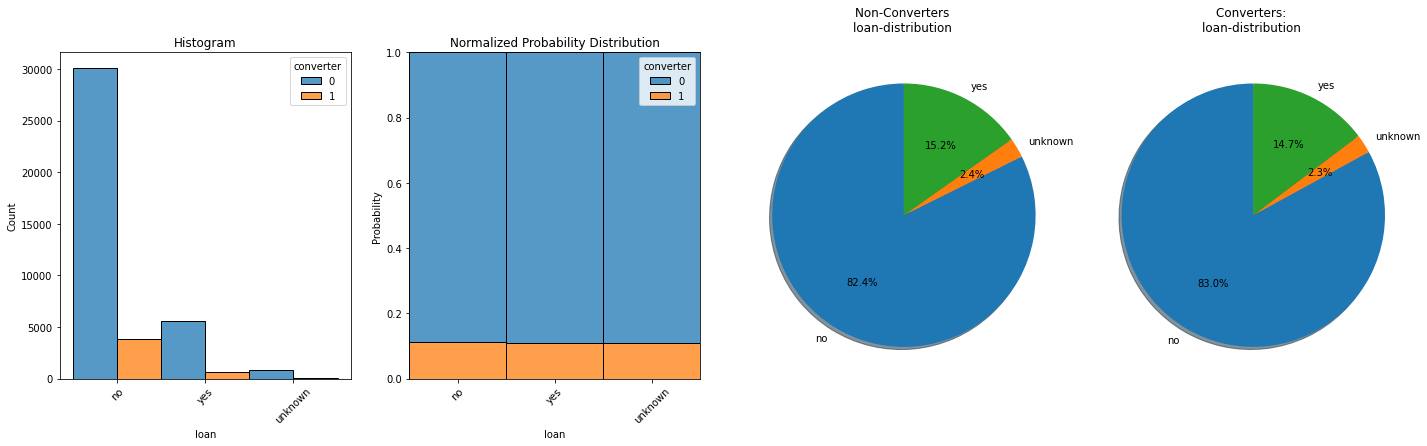

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


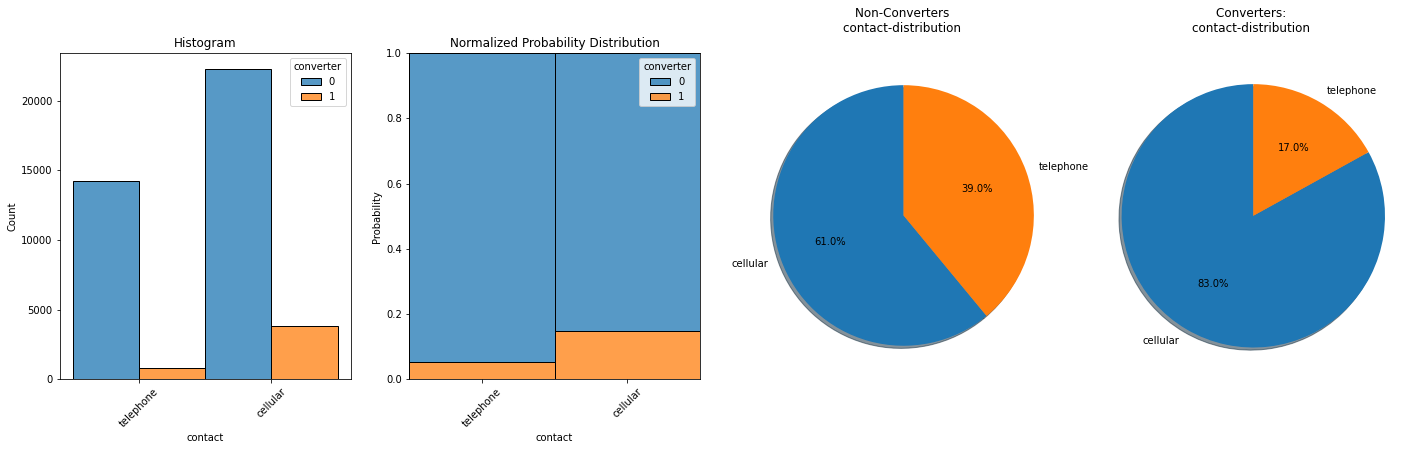

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


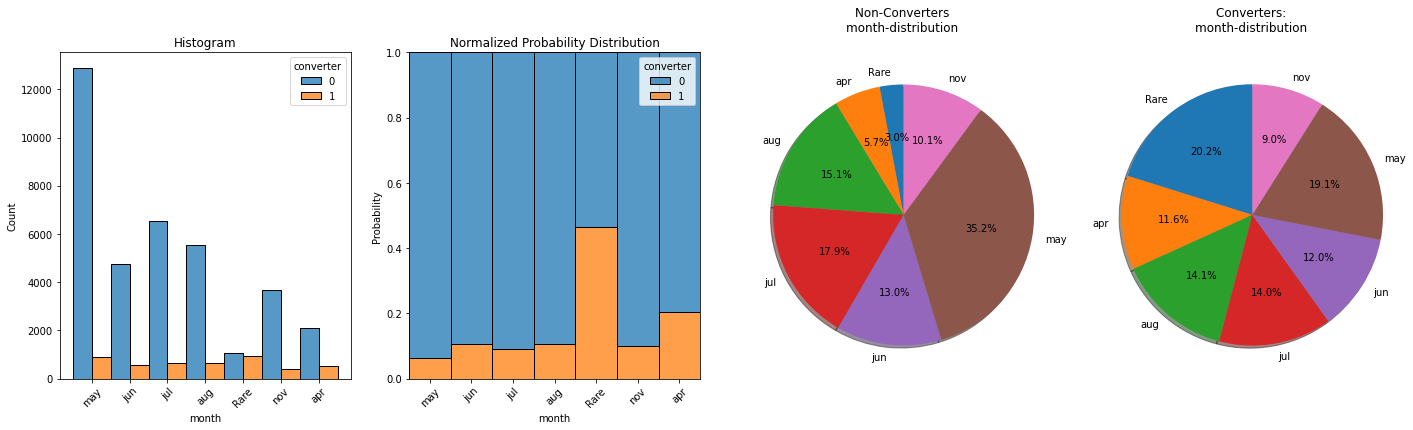

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


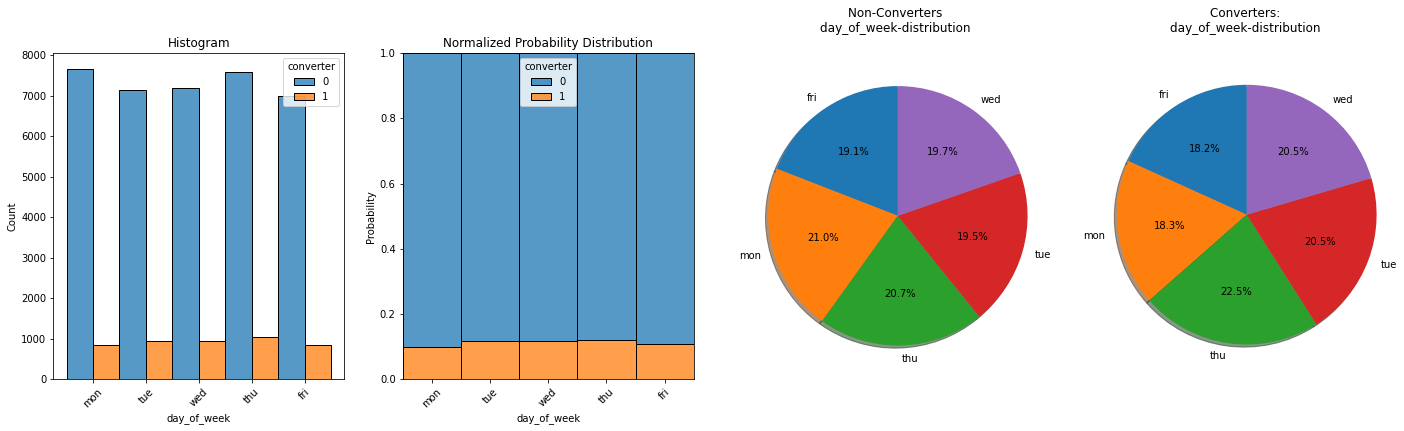

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


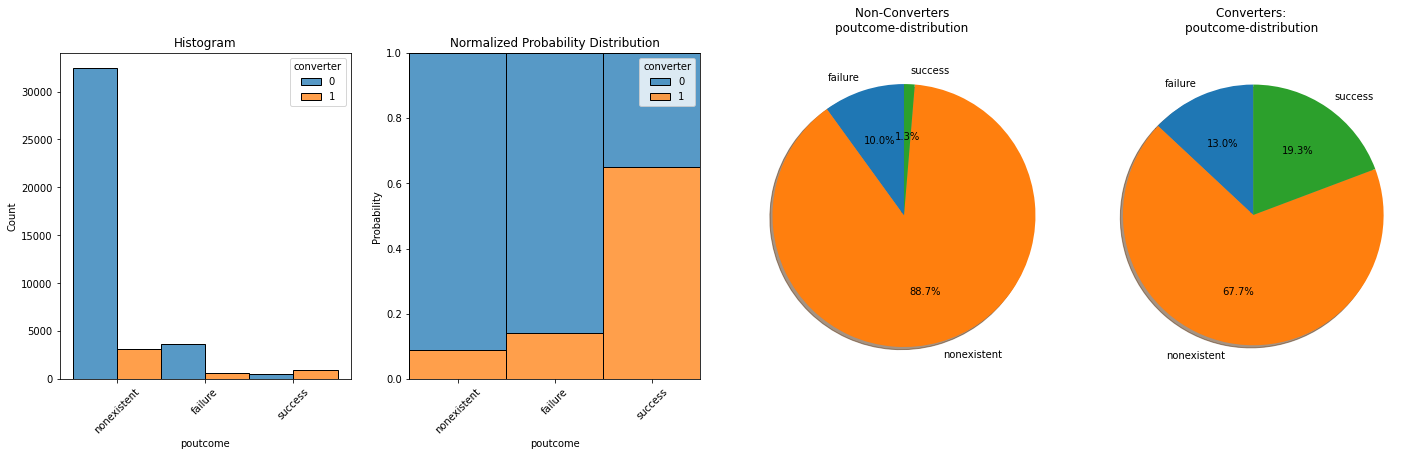

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


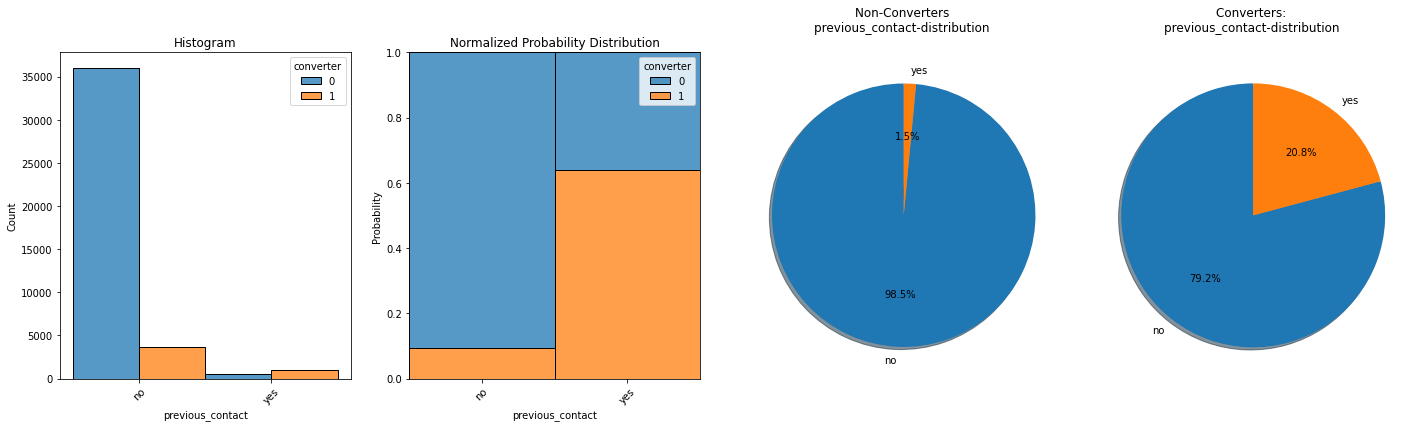

In [11]:
# plot histograms
for feat in categorical_columns:

    fig, ax = plt.subplots(1, 4, figsize=(24,6))

    sns.histplot(
        data = df,
        x = feat,
        hue = 'converter',
        stat='count',
        multiple='dodge',
        ax = ax[0]
    )
    ax[0].set_xticklabels(df[feat].unique(), rotation=45)
    ax[0].set_title('Histogram')

    sns.histplot(
        data = df,
        x = feat,
        hue = 'converter',
        stat='probability',
        multiple='fill',
        ax = ax[1]
    )
    ax[1].set_xticklabels(df[feat].unique(), rotation=45)
    ax[1].set_title('Normalized Probability Distribution')

    # pie-plot for the non-converter
    tmp =  df[df['converter']==0].groupby(by=[feat]).count().iloc[:,0] / df[df['converter']==0].shape[0]
    ax[2].pie(
            x=tmp.values.tolist(), 
            labels=tmp.index.to_list(), 
            autopct='%1.1f%%', 
            shadow=True, 
            startangle=90
        )
    ax[2].set_title('Non-Converters \n'+feat+'-distribution \n')
    ax[2].axis('equal')

    # pie-plot for the converter
    tmp =  df[df['converter']==1].groupby(by=[feat]).count().iloc[:,0] / df[df['converter']==1].shape[0]
    ax[3].pie(
            x=tmp.values.tolist(), 
            labels=tmp.index.to_list(), 
            autopct='%1.1f%%', 
            shadow=True, 
            startangle=90
        )
    ax[3].set_title('Converters: \n'+feat+'-distribution \n')
    ax[3].axis('equal')

    plt.show()

# Export Notebook as PDF

In [12]:
# Export Notebook as PDF
!jupyter nbconvert 12_customer_seg_bankchurndata_report.ipynb --output-dir='../reports' --to pdf --no-input --output Customer_Segmentation_Report.pdf

This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

C:\Users\Nutzer\.conda\envs\customer_analytics\lib\site-packages\traitlets\traitlets.py:2389: FutureWarning: Supporting extra quotes around strings is deprecated in traitlets 5.0. You can use '../reports' instead of "'../reports'" if you require traitlets >=5.
  warn(
[NbConvertApp] WARNING | pattern '12_customer_seg_bankchurndata_report.ipynb' matched no files
